In [114]:
# # 1. 가상환경 생성 및 활성화
# python -m venv LangGraph_Test
# # Windows
# LangGraph_Test\Scripts\activate

# # 2. 필요한 패키지 설치
# pip install jupyter notebook
# pip install ipykernel

# # 3. 가상환경을 Jupyter kernel로 등록
# python -m ipykernel install --user --name=LangGraph_Test --display-name="LangGraph_Test"

In [115]:
from typing import Annotated, TypedDict, Optional, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_community.utilities import SerpAPIWrapper
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain.agents import create_tool_calling_agent
from langchain_core.pydantic_v1 import BaseModel, Field
# from langchain.agents import load_tools
import os
import json
import requests

In [116]:
# api key
from dotenv import load_dotenv

load_dotenv()

True

In [117]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LANGGRAPH")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LANGGRAPH


In [118]:
# State 정의
class State(BaseModel):
    messages: Annotated[list, add_messages]
    fng: Optional[dict] = None
    news_search: Optional[dict] = None
    master: Optional[dict] = None

In [119]:
llm = ChatOpenAI(model="gpt-4", temperature=0)

In [120]:
# 공포 탐욕 지수 함수
url = "https://api.alternative.me/fng/?date_format=kr&limit="

def get_fng():
    _url = url + "30"
    res = requests.request("GET", _url)
    parsed = json.loads(res.text)
    data = parsed["data"]
    info = [int(item['value']) for item in data]
    return info

# fng_agent 정의
fng_template = """당신은 투자 분석 전문가 입니다.
    Level 1: 0-25 points — Extreme Fear: Indicates a high level of pessimism; investors are highly risk-averse.
    Level 2: 26-50 points — Fear: Suggests cautious sentiment; investors are generally reluctant to take on risk.
    Level 3: Around 50 points — Neutral: Shows a balanced market sentiment with neither fear nor greed prevailing.
    Level 4: 51-75 points — Greed: Investors are becoming more optimistic, showing a greater willingness to take on risk.
    Level 5: 76-100 points — Extreme Greed: Indicates very high levels of optimism; investors are extremely risk-seeking.

    현재 공포 탐욕 지수의 최근 30일 지수의 정보는 다음과 같습니다:
    {info}

    분석 결과를 다음 JSON 형식으로 제공해주세요:
    {{
        "decision": "BUY 또는 SELL 또는 HOLD 중 하나로만 작성",
        "summary": "시장 분석 및 예측 내용을 상세히 서술. 투자 결정을 제안하고 해당 이유를 서술",
    }}

    주의사항:
    - decision은 반드시 BUY 또는 SELL 또는 HOLD 중 하나여야 합니다
    - summary는 현재 시장 상황과 향후 전망을 포함해야 합니다. 투자 결정을 제안하고 해당 이유를 서술해야 합니다
    """
fng_prompt_template = PromptTemplate.from_template(fng_template)

class FngAnalysis(TypedDict):
    summary: str
    decision: Literal["BUY", "SELL", "HOLD"]

json_output_parser = JsonOutputParser(pydantic_object=FngAnalysis)
fng_chain = fng_prompt_template | llm | json_output_parser

def fng_agent(state: State) -> State:
    # 공포 탐욕 지수 메시지
    fng_info = get_fng()
    result = fng_chain.invoke({"info": fng_info})
    
    # 메시지를 추가
    new_message = f"FNG Analysis Decision: {result['decision']}, Summary: {result['summary']}"
    updated_messages = state.messages + [new_message]
    
    # 상태 업데이트
    return state.copy(update={"messages": updated_messages, "fng": {"decision": result["decision"], "summary": result["summary"]}})

In [121]:
# 뉴스 검색 에이전트
search = SerpAPIWrapper()

news_search_template = """당신은 비트코인 시장의 투자 분석 전문가입니다. 
    최신 뉴스에서 비트코인 관련 시장 동향을 조사하고 이를 분석하여 결정하세요.
    
    다음의 뉴스 기사들을 참조하여 BUY, SELL, HOLD 중 하나의 결정을 내리세요:
    {articles}

    결과는 반드시 JSON 형식으로 출력하세요:
    {{
        "decision": "BUY 또는 SELL 또는 HOLD 중 하나로만 작성",
        "summary": "뉴스 동향에 기반한 시장 분석과 투자 결정을 서술",
        "sources": ["뉴스 기사 링크를 포함해 주세요"]
    }}
    """
news_search_prompt_template = PromptTemplate.from_template(news_search_template)

class NewsSearchAnalysis(BaseModel):
    summary: str
    decision: Literal["BUY", "SELL", "HOLD"]
    sources: list[str]

news_output_parser = JsonOutputParser(pydantic_object=NewsSearchAnalysis)
news_search_chain = news_search_prompt_template | llm | news_output_parser

def news_search_agent(state: State) -> State:
    # 뉴스 메시지
    search_results = search.run("bitcoin latest news")
    articles = "\n".join([f"- {item['title']} ({item['link']})" for item in search_results[:5]])

    # 모델에 기사 제목과 링크 포함해 프롬프트 생성 및 응답 요청
    result = news_search_chain.invoke({"articles": articles})

    # 새로운 메시지 추가
    new_message = f"News Search Decision: {result['decision']}, Summary: {result['summary']}, Sources: {result['sources']}"
    updated_messages = state.messages + [new_message]
    
    # 상태 업데이트
    return state.copy(update={"messages": updated_messages, "news_search": {"decision": result["decision"], "summary": result["summary"], "sources": result["sources"]}})

In [122]:
# 마스터 에이전트
master_template = """당신은 비트코인 시장의 투자 분석 전문가입니다.
    현재 당신 회사에 속한 투자 전문가들은 비트코인 투자 결정을 다음과 같이 했습니다:
    {master_decision}
    당신은 해당 결정을 따르기로 했습니다.
    
    해당 결정을 뒷받침하는 투자 전문가들의 의견을 종합해주세요:
    {contents}
    
    만약, 투자전문가들의 의견이 "DRAW"라면 당신이 전반적인 내용을 종합하여 "BUY", "SELL", "HOLD" 중 하나를 골라주세요.
    해당 결정을 가지고 투자 자본을 얼만큼의 비중으로 진행할지 퍼센트도 결정해주세요.

    결과는 반드시 JSON 형식으로 출력하세요:
    {{
        "decision": "BUY 또는 SELL 또는 HOLD 중 하나로만 작성",
        "percentage": "현재 가지고 있는 자본 중 몇 퍼센트를 의사결정 할지 0부터 50까지 10 단위로 작성. 만약 HOLD면 0으로 설정",
        "summary": "투자 결정에 대한 이유를 자세히 서술",
    }}

    주의사항:
    - decision은 반드시 BUY 또는 SELL 또는 HOLD 중 하나여야 합니다
    """

master_prompt_template = PromptTemplate.from_template(master_template)

class MasterAnalysis(BaseModel):
    summary: str
    percentage: int
    decision: Literal["BUY", "SELL", "HOLD"]

master_output_parser = JsonOutputParser(pydantic_object=MasterAnalysis)
master_chain = master_prompt_template | llm | master_output_parser

def count_decision(decision: Optional[str]) -> tuple[int, int, int]:
    """
    단일 결정에 대해 BUY/SELL/HOLD 카운트를 반환합니다.
    각 결정은 하나의 값만 가질 수 있으므로 (1,0,0), (0,1,0), (0,0,1) 중 하나를 반환합니다.
    반환값 순서: (BUY, SELL, HOLD)
    """
    if not decision:
        return (0, 0, 0)
    
    if decision == "BUY":
        return (1, 0, 0)
    elif decision == "SELL":
        return (0, 1, 0)
    elif decision == "HOLD":
        return (0, 0, 1)
    return (0, 0, 0)  # 유효하지 않은 결정의 경우

def master_agent(state: State) -> State:
    # 초기 카운트 값들 (BUY, SELL, HOLD 순서)
    total_buy = 0
    total_sell = 0
    total_hold = 0

    # 1. Fear & Greed 결정 카운트
    if state.fng and "decision" in state.fng:
        buy, sell, hold = count_decision(state.fng["decision"])
        total_buy += buy
        total_sell += sell
        total_hold += hold

    # 2. 뉴스 검색 결정 카운트
    if state.news_search and "decision" in state.news_search:
        buy, sell, hold = count_decision(state.news_search["decision"])
        total_buy += buy
        total_sell += sell
        total_hold += hold

    # 투표 결과 결정 (BUY, SELL, HOLD 순서로 조건 체크)
    if total_buy > total_sell and total_buy > total_hold:
        master_decision = "BUY"
    elif total_sell > total_buy and total_sell > total_hold:
        master_decision = "SELL"
    elif total_hold > total_buy and total_hold > total_sell:
        master_decision = "HOLD"
    else:
        master_decision = "DRAW"

    print(f"decision count: BUY({total_buy}), SELL({total_sell}), HOLD({total_hold})")
    print(f"Master: {master_decision}")

    # 마스터 결정 진행
    result = master_chain.invoke({
        "master_decision": master_decision, 
        "contents": state.messages
    })

    return state.copy(update={"messages": state.messages,"master": {"decision": result["decision"], "percentage": result["percentage"], "summary": result["summary"]}})


In [123]:
# 병렬 방식
# 그래프 생성 및 노드 추가
graph_builder = StateGraph(State)

# 병렬 실행을 위해 각 노드를 START에서 바로 실행
graph_builder.add_node("fng_agent", fng_agent)
graph_builder.add_node("news_search_agent", news_search_agent)
graph_builder.add_node("master_agent", master_agent)

# START에서 두 노드를 동시에 실행하고 END로 연결
graph_builder.add_edge(START, "fng_agent")
graph_builder.add_edge(START, "news_search_agent")

graph_builder.add_edge("fng_agent", "master_agent")
graph_builder.add_edge("news_search_agent", "master_agent")
graph_builder.add_edge("master_agent", END)

# 그래프 컴파일
graph = graph_builder.compile()

In [124]:
# # 직렬 방식
# # 그래프 생성 및 노드 추가
# graph_builder = StateGraph(State)

# # 병렬 실행을 위해 각 노드를 START에서 바로 실행
# graph_builder.add_node("fng_agent", fng_agent)
# graph_builder.add_node("news_search_agent", news_search_agent)
# graph_builder.add_node("master_agent", master_agent)

# # START에서 두 노드를 동시에 실행하고 END로 연결
# graph_builder.add_edge(START, "fng_agent")
# graph_builder.add_edge("fng_agent", "news_search_agent")
# graph_builder.add_edge("news_search_agent", "master_agent")
# graph_builder.add_edge("master_agent", END)

# # 그래프 컴파일
# graph = graph_builder.compile()

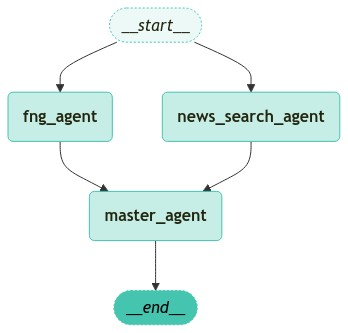

In [125]:
# 결과 시각화
from langchain_teddynote.graphs import visualize_graph
visualize_graph(graph)

In [126]:
# 그래프 실행
initial_state = State(messages=[("user", "각 에이전트가 서로 다른 메시지를 받아 분석하세요.")])
result_state = graph.invoke(initial_state)

decision count: BUY(2), SELL(0), HOLD(0)
Master: BUY


In [127]:
def default_serializer(obj):
    return obj.__dict__

print(json.dumps(result_state, indent=4, ensure_ascii=False, default=default_serializer))

{
    "messages": [
        {
            "content": "각 에이전트가 서로 다른 메시지를 받아 분석하세요.",
            "additional_kwargs": {},
            "response_metadata": {},
            "type": "human",
            "name": null,
            "id": "df3546d2-6b2b-4b27-be7a-f93e6aa421e7",
            "example": false
        },
        {
            "content": "FNG Analysis Decision: BUY, Summary: 지난 30일 동안의 공포 탐욕 지수를 보면, 초기에는 'Extreme Greed' 상태에서 시작하여 점차 'Fear' 상태로 변화하였습니다. 이는 투자자들이 점차 위험을 회피하는 경향을 보였음을 의미합니다. 그러나 최근에는 다시 'Neutral'에서 'Greed' 상태로 변화하였습니다. 이는 투자자들이 다시 위험을 감수하려는 경향이 생겼음을 나타냅니다. 이러한 변화는 시장의 변동성이 높아질 수 있음을 시사하며, 이는 투자 기회를 제공할 수 있습니다. 따라서 현재는 'BUY' 결정을 제안합니다. 그러나 시장 상황은 빠르게 변할 수 있으므로, 투자자들은 계속해서 시장 동향을 주시해야 합니다.",
            "additional_kwargs": {},
            "response_metadata": {},
            "type": "human",
            "name": null,
            "id": "c2d77c0a-2828-41d3-9018-258ad89fa81d",
            "example": false
        },
        {
            "content": "News Search Decision:

In [128]:
print(result_state["fng"])
print(result_state["news_search"])
print(result_state["master"])

{'decision': 'BUY', 'summary': "지난 30일 동안의 공포 탐욕 지수를 보면, 초기에는 'Extreme Greed' 상태에서 시작하여 점차 'Fear' 상태로 변화하였습니다. 이는 투자자들이 점차 위험을 회피하는 경향을 보였음을 의미합니다. 그러나 최근에는 다시 'Neutral'에서 'Greed' 상태로 변화하였습니다. 이는 투자자들이 다시 위험을 감수하려는 경향이 생겼음을 나타냅니다. 이러한 변화는 시장의 변동성이 높아질 수 있음을 시사하며, 이는 투자 기회를 제공할 수 있습니다. 따라서 현재는 'BUY' 결정을 제안합니다. 그러나 시장 상황은 빠르게 변할 수 있으므로, 투자자들은 계속해서 시장 동향을 주시해야 합니다."}
{'decision': 'BUY', 'summary': '비트코인 가격이 7개월 만에 최고치인 73,000달러를 돌파하였고, 이는 선거와 인플레이션에 대한 불확실성으로 인한 것으로 보입니다. 또한, 미국 대통령이 나이지리아의 암호화폐 협력과 글로벌 개혁을 칭찬하였으며, 이는 암호화폐에 대한 긍정적인 시그널로 해석될 수 있습니다. 그러나 소매 투자자들 사이에서는 비트코인에 대한 관심이 여전히 낮아, 이는 가격 상승의 추가적인 잠재력을 시사할 수 있습니다. 따라서, 현재의 시장 상황을 고려할 때, 비트코인을 매입하는 것이 바람직해 보입니다.', 'sources': ['https://www.forbes.com/sites/dereksaul/2024/10/29/bitcoin-tops-71000-a-5-month-high-as-election-inflation-questions-swirl/', 'https://www.cnbc.com/2024/10/28/crypto-market-today.html', 'https://news-bitcoin-com.webpkgcache.com/doc/-/s/news.bitcoin.com/us-president-biden-applauds-nigerias-crypto-cooperation-and-pu